In [1]:
import nbsetup
import torch
import matplotlib.pyplot as plt

from functional import Functional
from tensor import Tensor
from dict import Dict

# Effect of diffusivity and temperature on convergence 

In [2]:
from system import System

K = System(('i:j:k', 'i:k:l', 'j:k:l'))

In [3]:
# Operators 

d, delta = K.D[0], K.Delta[1]
zeta, mu1 = K.Zeta[0], K.Mu[1]

DF = K.Deff[0]

In [4]:
def diffusion(D, normalise=False):
    Z = zeta
    if normalise: 
        N = Functional({
            (a|a): lambda Ua: Ua - K.F[a](Ua) for _, a in K.N[0]
        }).curry()
        Z = N @ zeta
    out = Dict()
    out.potential = -1 * delta @ D @ zeta
    out.energy = -1 *  zeta @ delta @ D
    Phi = -1 * D @ zeta
    out.flux = lambda u: lambda phi: Phi(u + delta(phi))
    return out

# GBP diffusion
GBP = diffusion(DF, normalise=True)

# Diffusion with Möbius inversion on messages
muGBP = diffusion(mu1 @ DF)

In [48]:
Nit = 10
def integrate(u0, rate=0.5, Nit=Nit, diffusion=GBP):
    flux = diffusion.flux(u0)
    phi = K.zeros(1)
    out = Dict({
        'phi': [Tensor() for i in range(Nit)],
        'dphi': [Tensor() for i in range(Nit)]
    })
    for t in range(Nit):
        dphi = flux(phi)
        phi = phi + rate * dphi
        out.dphi[t] = dphi
        out.phi[t] = phi
    return out

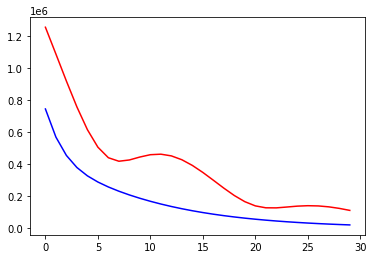

In [205]:
""" Plot heat flux norm over time """

# Temperature
T = 0.00001
u = (1/T) * K.gaussian(0) 

# 1: GBP diffusion
orbit1 = integrate(u0, 0.1, 30)
# 2: Bethe diffusion
orbit2 = integrate(u0, 0.1, 30, muGBP)

# norms
t = [i for i in range(30)]
n1 = [psi.norm() for psi in orbit1.dphi]
n2 = [psi.norm() for psi in orbit2.dphi]

plt.plot(t, n1, color="red")
plt.plot(t, n2, color="blue")

## Convergence Ratios

In [209]:
def convergenceRatio(u0, rate=0.5, N=Nit, diffusion=GBP):
    flux = diffusion.flux(u0)
    phi = K.zeros(1)
    dphi = flux(phi)
    DZ = DF @ zeta
    D0 = DZ(u0 + delta(phi))
    for t in range(Nit - 1):
        phi += rate * dphi
        dphi = flux(phi)    
    D1 = DZ(u0 + delta(phi))
    return D1.norm()/D0.norm()

In [210]:
from time import time 

table = Dict()

In [241]:
# Parameters
T = 1e6
beta = 1/T
samples = 20
rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Loop: 

t0 = time()
N = len(rates) * Nit * samples

print(f"running {samples * 2} diffusions with {Nit} iterations per diffusivity:")
print(f"\t\tT = {T}")

for r in rates:
    table[r] = [[], []]
    for s in range(samples):
        u = beta * K.gaussian(0)
        table[r][0] += [float(convergenceRatio(u, rate=r, N=10, diffusion=GBP))]
        table[r][1] += [float(convergenceRatio(u, rate=r, N=10, diffusion=muGBP))]
    print(f'... {r}')
  
t1 = time()
print(f"completed {N} iterations in {t1 - t0:.2f} s")
print(f'{(t1-t0) * 1000/N:.2f} ms/it')
print(f'{N / (t1 - t0):.0f} it/s')

running 40 diffusions with 10 iterations per diffusivity:
		T = 1000000.0
... 0.1
... 0.2
... 0.3
... 0.4
... 0.5
... 0.6
... 0.7
... 0.8
completed 1600 iterations in 117.20 s
73.25 ms/it
14 it/s


In [242]:
import csv

threshold = 0.4

filterCvg = lambda cs: [c for c in cs if c < threshold]
percentCvg = lambda cs: float(len(filterCvg(cs))) / len(cs)
avg = lambda cs: sum(c for c in cs) / len(cs)

Cvg = table.fmap(
    lambda orbits: [percentCvg(cs) for cs in orbits]
)
Avg = table.fmap(
    lambda orbits: [f'{avg(cs):.2f}' for cs in orbits]
)

linesCvg = [[], []]
linesAvg = [[], []]

for r in rates: 
    
    linesCvg[0] += [Cvg[r][0]]
    linesCvg[1] += [Cvg[r][1]]
    
    linesAvg[0] += [Avg[r][0]]
    linesAvg[1] += [Avg[r][1]]


print(f"averages:")
print(linesAvg)
print(f"convergent:")
print(linesCvg)

averages:
[['0.43', '0.26', '0.47', '0.88', '2.31', '6.02', '26.38', '64.49'], ['0.15', '0.24', '0.34', '0.37', '0.38', '0.41', '1.18', '8.65']]
convergent:
[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]]


In [243]:
T = 1. / beta
file = f'data/cvg.csv'
file2 = f'data/val.csv'

print("...")
with open(file, 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([T, 'T', beta, 'beta', threshold, 'cut'])
    writer.writerow(linesCvg[0])
    writer.writerow(linesCvg[1])
    writer.writerow(rates)
    writer.writerow([])

with open(file2, 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([T, 'T', beta, 'beta'])
    writer.writerow(linesAvg[0])
    writer.writerow(linesAvg[1])
    writer.writerow(rates)
    writer.writerow([])
    
print(f"wrote lines for T={T} threshold {threshold}")

...
wrote lines for T=1000000.0 threshold 0.4
